In [22]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import requests
import subprocess
import zipfile
import soundfile as sf
from pathlib import Path

from datasets import load_dataset, Audio , Dataset

In [2]:
import os, shutil

# Prepend ~/.local/bin to PATH so that `yt-dlp` is found
local_bin = os.path.expanduser("~/.local/bin")
os.environ["PATH"] = local_bin + os.pathsep + os.environ.get("PATH", "")

# Verify:
print("yt-dlp →", shutil.which("yt-dlp"))
print("ffmpeg →", shutil.which("ffmpeg"))


yt-dlp → /home/akar/.local/bin/yt-dlp
ffmpeg → /usr/bin/ffmpeg


# Caption + Audio Data

In [3]:
df = pd.read_csv('musiccaps-public.csv')
hf_ds = Dataset.from_pandas(df)

df.head()

,ytid,start_s,end_s,audioset_positive_labels,aspect_list,caption,author_id,is_balanced_subset,is_audioset_eval
0,-0Gj8-vB1q4,30,40,"/m/0140xf,/m/02cjck,/m/04rlf","['low quality', 'sustained strings melody', 's...",The low quality recording features a ballad so...,4,False,True
1,-0SdAVK79lg,30,40,"/m/0155w,/m/01lyv,/m/0342h,/m/042v_gx,/m/04rlf...","['guitar song', 'piano backing', 'simple percu...",This song features an electric guitar as the m...,0,False,False
2,-0vPFx-wRRI,30,40,"/m/025_jnm,/m/04rlf","['amateur recording', 'finger snipping', 'male...",a male voice is singing a melody with changing...,6,False,True
3,-0xzrMun0Rs,30,40,"/m/01g90h,/m/04rlf","['backing track', 'jazzy', 'digital drums', 'p...",This song contains digital drums playing a sim...,6,False,True
4,-1LrH01Ei1w,30,40,"/m/02p0sh1,/m/04rlf","['rubab instrument', 'repetitive melody on dif...",This song features a rubber instrument being p...,0,False,False


In [9]:
hf_ds

Dataset({
    features: ['ytid', 'start_s', 'end_s', 'audioset_positive_labels', 'aspect_list', 'caption', 'author_id', 'is_balanced_subset', 'is_audioset_eval'],
    num_rows: 5521
})

In [35]:
# ! pip install datasets[audio] yt-dlp
# !pip install yt-dlp ffmpeg-python datasets pandas

In [40]:
def download_clip(video_identifier, output_filename, start_time, end_time, tmp_dir='/tmp/musiccaps', num_attempts=5, url_base='https://www.youtube.com/watch?v='):
    status = False

    command = f"""yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "{output_filename}" --download-sections "*{start_time}-{end_time}" {url_base}{video_identifier}""".strip()

    attempts = 0
    while True:
        try:
            output = subprocess.check_output(command, shell=True,
                                                stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as err:
            attempts += 1
            if attempts == num_attempts:
                return status, err.output
        else:
            break

    # Check if the video was successfully saved.
    status = os.path.exists(output_filename)
    return status, 'Downloaded'


def main(data_dir, sampling_rate=32000, limit=None, num_proc=1, writer_batch_size=1000):
    """
    Download the clips within the MusicCaps dataset from YouTube.
    Args:
        data_dir: Directory to save the clips to.
        sampling_rate: Sampling rate of the audio clips.
        limit: Limit the number of examples to download.
        num_proc: Number of processes to use for downloading.
        writer_batch_size: Batch size for writing the dataset. This is per process.
    """

    ds = Dataset.from_pandas(df)#load_dataset('google/MusicCaps', split='train')
    if limit is not None:
        print(f"Limiting to {limit} examples")
        ds = ds.select(range(limit))

    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok=True, parents=True)

    def process(example):
        outfile_path = str(data_dir / f"{example['ytid']}.wav")
        status = True
        if not os.path.exists(outfile_path):
            status = False
            status, log = download_clip(
                example['ytid'],
                outfile_path,
                example['start_s'],
                example['end_s'],
            )

        example['audio'] = outfile_path
        example['download_status'] = status
        return example

    return ds.map(process, num_proc=num_proc, writer_batch_size=writer_batch_size, keep_in_memory=False).cast_column('audio', Audio(sampling_rate=sampling_rate))

In [5]:
def download_clip(video_identifier, output_filename, start_time, end_time, tmp_dir='/tmp/musiccaps', num_attempts=5, url_base='https://www.youtube.com/watch?v='):
    """
    Download a segment [start_time, end_time] from a YouTube video as a WAV file.
    Retries up to num_attempts times if yt-dlp fails.
    Returns (success_bool, message_or_error).
    """
    print(f"[download_clip] video_id={video_identifier}, segment={start_time}-{end_time}, saving to {output_filename}")
    status = False
    command = (
        'yt-dlp --quiet --no-warnings -x --audio-format wav '
        '-f bestaudio '
        f'-o "{output_filename}" '
        f'--download-sections "*{start_time}-{end_time}" '
        f'{url_base}{video_identifier}'
    )
    attempts = 0

    while True:
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as err:
            attempts += 1
            print(f"  [download_clip] Attempt {attempts} failed: {err.output[:100]!r}...")
            if attempts >= num_attempts:
                return False, err.output.decode('utf-8', errors='ignore')
        else:
            break

    if os.path.exists(output_filename):
        print(f"  [download_clip] SUCCESS: {output_filename}")
        return True, "Downloaded"
    else:
        print(f"  [download_clip] FAILURE: {output_filename} missing after yt-dlp")
        return False, "File not found after download"


def process(example, data_dir):
    """
    Mapping function for a single example of the MusicCaps dataset.
    Downloads the WAV clip if it does not exist, and records `download_status`.
    """
    ytid = example.get('ytid')
    start_s = example.get('start_s')
    end_s = example.get('end_s')

    # Debug: verify fields exist
    if ytid is None or start_s is None or end_s is None:
        print(f"[process] Missing field in example: ytid={ytid}, start_s={start_s}, end_s={end_s}")
        example['download_status'] = False
        example['audio'] = None
        return example

    outfile_path = str(Path(data_dir) / f"{ytid}.wav")
    print(f"[process] ytid={ytid}, start_s={start_s}, end_s={end_s}, outfile={outfile_path}")

    if not os.path.exists(outfile_path):
        success, log = download_clip(ytid, outfile_path, start_s, end_s)
        example['download_status'] = success
        if not success:
            print(f"  [process] Download failed for {ytid}: {log}")
    else:
        print(f"  [process] File already exists: {outfile_path}")
        example['download_status'] = True

    example['audio'] = outfile_path if example['download_status'] else None
    return example


def main(data_dir, df, sampling_rate=32000, limit=None, num_proc=1, writer_batch_size: int = 1000):
    """
    Download the clips within the MusicCaps dataset from YouTube and return a HF Dataset
    that includes a new `audio` column (path to the .wav) and `download_status`.
    """

    # 1) Convert pandas DataFrame to HF Dataset
    hf_ds = Dataset.from_pandas(df)

    # 2) Optionally limit the number of examples
    if limit is not None:
        print(f"[main] Limiting to first {limit} examples")
        hf_ds = hf_ds.select(range(limit))

    # 3) Ensure output directory exists
    data_dir = Path(data_dir)
    data_dir.mkdir(parents=True, exist_ok=True)

    # 4) Wrap process() so .map() sees data_dir
    def _wrapped_process(example):
        return process(example, data_dir)

    print("[main] Starting .map() over the dataset…")
    ds_with_audio = hf_ds.map(
        _wrapped_process,
        num_proc=num_proc,
        batched=False,
        remove_columns=[],
        writer_batch_size=writer_batch_size,
    )

    # 5) Cast the `audio` column to Audio feature type
    ds_with_audio = ds_with_audio.cast_column('audio', Audio(sampling_rate=sampling_rate))

    print("[main] .map() complete.")
    return ds_with_audio


#    # 1) Load your musiccaps-public.csv into pandas
    df = pd.read_csv("musiccaps-public.csv")
    print(f"DataFrame loaded with {len(df)} rows. Columns: {df.columns.tolist()}")

    # 2) Call main(), saving clips under "music_data"
    result_ds = main(
        data_dir="music_data",
        df=df,
        sampling_rate=32000,
        limit=50,     # for testing, just grab 50 clips
        num_proc=2,   # two parallel processes
        writer_batch_size=10
    )

    print("[__main__] Final Dataset sample:")
    print(result_ds.select(range(5)))


In [8]:
df = pd.read_csv("musiccaps-public.csv")
print(f"DataFrame loaded with {len(df)} rows. Columns: {df.columns.tolist()}")

result_ds = main(data_dir="music_data", df=df, sampling_rate=32000, limit=1000, num_proc=8, writer_batch_size=10)

DataFrame loaded with 5521 rows. Columns: ['ytid', 'start_s', 'end_s', 'audioset_positive_labels', 'aspect_list', 'caption', 'author_id', 'is_balanced_subset', 'is_audioset_eval']
[main] Limiting to first 1000 examples
[main] Starting .map() over the dataset…


Map (num_proc=8):   0%|          | 0/1000 [00:00<?, ? examples/s]

[process] ytid=-0Gj8-vB1q4, start_s=30, end_s=40, outfile=music_data/-0Gj8-vB1q4.wav
  [process] File already exists: music_data/-0Gj8-vB1q4.wav
[process] ytid=-0SdAVK79lg, start_s=30, end_s=40, outfile=music_data/-0SdAVK79lg.wav
  [process] File already exists: music_data/-0SdAVK79lg.wav
[process] ytid=-0vPFx-wRRI, start_s=30, end_s=40, outfile=music_data/-0vPFx-wRRI.wav
  [process] File already exists: music_data/-0vPFx-wRRI.wav
[process] ytid=-0xzrMun0Rs, start_s=30, end_s=40, outfile=music_data/-0xzrMun0Rs.wav
  [process] File already exists: music_data/-0xzrMun0Rs.wav
[process] ytid=-1LrH01Ei1w, start_s=30, end_s=40, outfile=music_data/-1LrH01Ei1w.wav
  [process] File already exists: music_data/-1LrH01Ei1w.wav
[process] ytid=-1OlgJWehn8, start_s=30, end_s=40, outfile=music_data/-1OlgJWehn8.wav
  [process] File already exists: music_data/-1OlgJWehn8.wav
[process] ytid=-1UWSisR2zo, start_s=30, end_s=40, outfile=music_data/-1UWSisR2zo.wav
  [process] File already exists: music_data/-

# Audio Files

In [13]:
dataroot = 'music_data/'
wav_files = os.listdir('music_data')

In [14]:
audio, sr = librosa.load(dataroot + wav_files[0], sr=None) 
ipd.Audio(audio, rate=sr)


In [15]:
result_ds

Dataset({
    features: ['ytid', 'start_s', 'end_s', 'audioset_positive_labels', 'aspect_list', 'caption', 'author_id', 'is_balanced_subset', 'is_audioset_eval', 'download_status', 'audio'],
    num_rows: 1000
})

# Data Preprocessing and EDA

In [59]:
eda_df = result_ds.to_pandas()
eda_df = eda_df[eda_df['download_status'] == True].reset_index(drop=True)
eda_df['file_path'] = eda_df['ytid'].apply(lambda y: f"music_data/{y}.wav")

eda_df.head()

,ytid,start_s,end_s,audioset_positive_labels,aspect_list,caption,author_id,is_balanced_subset,is_audioset_eval,download_status,audio,file_path
0,-0Gj8-vB1q4,30,40,"/m/0140xf,/m/02cjck,/m/04rlf","['low quality', 'sustained strings melody', 's...",The low quality recording features a ballad so...,4,False,True,True,"{'bytes': None, 'path': 'music_data/-0Gj8-vB1q...",music_data/-0Gj8-vB1q4.wav
1,-0SdAVK79lg,30,40,"/m/0155w,/m/01lyv,/m/0342h,/m/042v_gx,/m/04rlf...","['guitar song', 'piano backing', 'simple percu...",This song features an electric guitar as the m...,0,False,False,True,"{'bytes': None, 'path': 'music_data/-0SdAVK79l...",music_data/-0SdAVK79lg.wav
2,-0vPFx-wRRI,30,40,"/m/025_jnm,/m/04rlf","['amateur recording', 'finger snipping', 'male...",a male voice is singing a melody with changing...,6,False,True,True,"{'bytes': None, 'path': 'music_data/-0vPFx-wRR...",music_data/-0vPFx-wRRI.wav
3,-0xzrMun0Rs,30,40,"/m/01g90h,/m/04rlf","['backing track', 'jazzy', 'digital drums', 'p...",This song contains digital drums playing a sim...,6,False,True,True,"{'bytes': None, 'path': 'music_data/-0xzrMun0R...",music_data/-0xzrMun0Rs.wav
4,-1LrH01Ei1w,30,40,"/m/02p0sh1,/m/04rlf","['rubab instrument', 'repetitive melody on dif...",This song features a rubber instrument being p...,0,False,False,True,"{'bytes': None, 'path': 'music_data/-1LrH01Ei1...",music_data/-1LrH01Ei1w.wav


### Relevant Metrics / Relationships:

- duration of music files, caption length relative to each music file, **trends between the two**

In [60]:
mapping_df = pd.read_csv('class_labels_indices.csv')
label_map = dict(zip(mapping_df.mid, mapping_df.display_name))

In [62]:
eda_df['caption_length'] = eda_df['caption'].str.split().apply(len)
durations = []
for fp in eda_df['file_path']:
    try:
        info = sf.info(fp)
        durations.append(info.duration)
    except Exception:
        print('error')
        durations.append(None)
eda_df['duration_s'] = durations
eda_df['labels'] = eda_df['audioset_positive_labels'].apply(lambda x: [label_map[lb] for lb in x.split(',')])
eda_df['num_labels'] = eda_df['labels'].apply(lambda x: len(x))

eda_df.head()

,ytid,start_s,end_s,audioset_positive_labels,aspect_list,caption,author_id,is_balanced_subset,is_audioset_eval,download_status,audio,file_path,caption_length,duration_s,labels,num_labels
0,-0Gj8-vB1q4,30,40,"/m/0140xf,/m/02cjck,/m/04rlf","['low quality', 'sustained strings melody', 's...",The low quality recording features a ballad so...,4,False,True,True,"{'bytes': None, 'path': 'music_data/-0Gj8-vB1q...",music_data/-0Gj8-vB1q4.wav,35,19.973500,"[Christmas music, Theme music, Music]",3
1,-0SdAVK79lg,30,40,"/m/0155w,/m/01lyv,/m/0342h,/m/042v_gx,/m/04rlf...","['guitar song', 'piano backing', 'simple percu...",This song features an electric guitar as the m...,0,False,False,True,"{'bytes': None, 'path': 'music_data/-0SdAVK79l...",music_data/-0SdAVK79lg.wav,101,19.973500,"[Blues, Country, Guitar, Acoustic guitar, Musi...",9
2,-0vPFx-wRRI,30,40,"/m/025_jnm,/m/04rlf","['amateur recording', 'finger snipping', 'male...",a male voice is singing a melody with changing...,6,False,True,True,"{'bytes': None, 'path': 'music_data/-0vPFx-wRR...",music_data/-0vPFx-wRRI.wav,37,19.973500,"[Finger snapping, Music]",2
3,-0xzrMun0Rs,30,40,"/m/01g90h,/m/04rlf","['backing track', 'jazzy', 'digital drums', 'p...",This song contains digital drums playing a sim...,6,False,True,True,"{'bytes': None, 'path': 'music_data/-0xzrMun0R...",music_data/-0xzrMun0Rs.wav,104,19.973500,"[Stomach rumble, Music]",2
4,-1LrH01Ei1w,30,40,"/m/02p0sh1,/m/04rlf","['rubab instrument', 'repetitive melody on dif...",This song features a rubber instrument being p...,0,False,False,True,"{'bytes': None, 'path': 'music_data/-1LrH01Ei1...",music_data/-1LrH01Ei1w.wav,49,10.007982,"[Traditional music, Music]",2


In [63]:
# relevant features

ftr_set = ['file_path', 'start_s', 'end_s', 'duration_s',  'aspect_list', 'caption', 'caption_length', 'num_labels', 'labels'] 
data = eda_df[ftr_set]
data.head()

,file_path,start_s,end_s,duration_s,aspect_list,caption,caption_length,num_labels,labels
0,music_data/-0Gj8-vB1q4.wav,30,40,19.973500,"['low quality', 'sustained strings melody', 's...",The low quality recording features a ballad so...,35,3,"[Christmas music, Theme music, Music]"
1,music_data/-0SdAVK79lg.wav,30,40,19.973500,"['guitar song', 'piano backing', 'simple percu...",This song features an electric guitar as the m...,101,9,"[Blues, Country, Guitar, Acoustic guitar, Musi..."
2,music_data/-0vPFx-wRRI.wav,30,40,19.973500,"['amateur recording', 'finger snipping', 'male...",a male voice is singing a melody with changing...,37,2,"[Finger snapping, Music]"
3,music_data/-0xzrMun0Rs.wav,30,40,19.973500,"['backing track', 'jazzy', 'digital drums', 'p...",This song contains digital drums playing a sim...,104,2,"[Stomach rumble, Music]"
4,music_data/-1LrH01Ei1w.wav,30,40,10.007982,"['rubab instrument', 'repetitive melody on dif...",This song features a rubber instrument being p...,49,2,"[Traditional music, Music]"


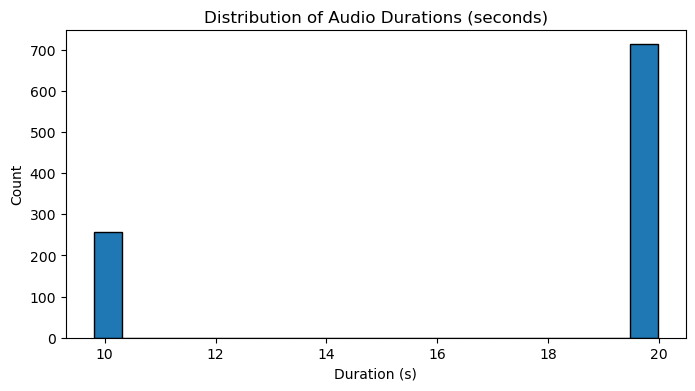

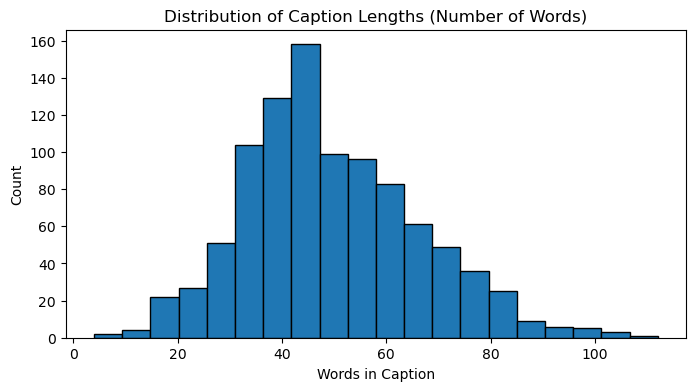

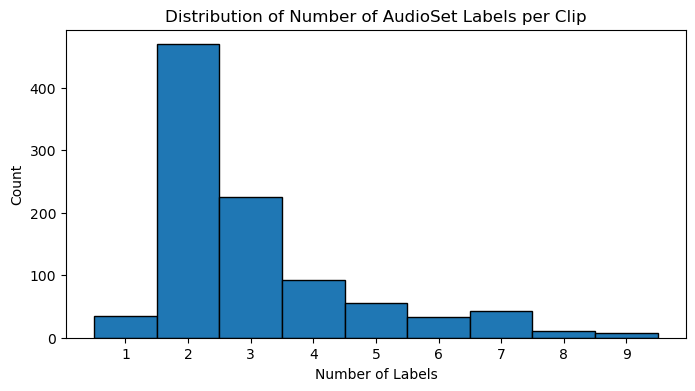

In [64]:
# Relevant Histogram Plots

plt.figure(figsize=(8, 4))
plt.hist(eda_df['duration_s'].dropna(), bins=20, edgecolor='k')
plt.title('Distribution of Audio Durations (seconds)')
plt.xlabel('Duration (s)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(eda_df['caption_length'], bins=20, edgecolor='k')
plt.title('Distribution of Caption Lengths (Number of Words)')
plt.xlabel('Words in Caption')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(eda_df['num_labels'], bins=range(1, eda_df['num_labels'].max()+2), edgecolor='k', align='left')
plt.title('Distribution of Number of AudioSet Labels per Clip')
plt.xlabel('Number of Labels')
plt.ylabel('Count')
plt.xticks(range(1, eda_df['num_labels'].max()+1))
plt.show()

### Analysis on Histograms

- Distribution of Audio Durations (seconds)
     - Most clips are 20 s long, with a smaller peak at around 10s --> dataset contains two standard snippet lengths (10s and 20s)
- Distribution of Caption Lengths (Number of Words)
     - Captions cluster around 35–55 words, with a long tail extending out to 100 + words
     - Noticeably fewer very short (< 20 words) or very long (> 80 words) captions (LLM generation consistently targets a mid‐range description length)
- Distribution of Number of AudioSet Labels per Clip
     - The majority of clips have 2 or 3 positive labels, with the single‐label cases being quite rare --> most musical segments are multi‐labeled (aim for good multi-label model)
     - Gradual drop‐off from 2 -> 3 -> 4 labels  --> extreme multi‐label clips are uncommon

In [81]:
label_set = eda_df['labels'].explode()
label_dist = label_set.value_counts(normalize=True).head(10)

print('Top 10 labels present')
print(label_dist)

Top 10 labels present
labels
Music                                   0.274303
Musical instrument                      0.036370
Guitar                                  0.025833
Plucked string instrument               0.023793
Singing                                 0.014616
Percussion                              0.012576
Speech                                  0.012237
Wind instrument, woodwind instrument    0.011557
Jazz                                    0.011217
Brass instrument                        0.009517
Name: proportion, dtype: float64
